In [1]:
from torch import nn
from torch.nn import functional as F
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import os
from matplotlib import pyplot as plt
import random
import numpy as np
from glob import glob
import tqdm
from PIL import Image, ImageEnhance, ImageOps, ImageFile
import numpy as np
import time
import logging
import os
import threading


BATCH_SIZE = 8
EPOCHS = 60
LEARNING_RATE = 0.001
RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DRIVE_PATH = os.path.join(os.getcwd(), "DRIVE", "DRIVE")
print(DRIVE_PATH, DEVICE)

e:\VSCODE\Python\DL-Hw\DRIVE\DRIVE cuda


## Data Augmentation:

### Flip

In [2]:
import cv2
from PIL import Image


image_flip_path = os.path.join(DRIVE_PATH, "training", "images")
image_flip_save_path = os.path.join(DRIVE_PATH, "training", "images_flip")

label_flip_path = os.path.join(DRIVE_PATH, "training", "1st_manual")
label_flip_save_path = os.path.join(DRIVE_PATH, "training", "1st_manual_flip")

def MakeDir(path):
    try:
        if not os.path.exists(path):
            if not os.path.isfile(path):
                # os.mkdir(path)
                os.makedirs(path)
            return 0
        else:
            return 1
    except Exception:
        print(str(Exception))
        return 0

def flip_images(path, save_path):
    """ Flip images vertically and save them """
    MakeDir(save_path)
    for name in os.listdir(path):
        if name.endswith(".tif"):
            image = cv2.imread(os.path.join(path, name))
            if image is not None:
                # Flipped Horizontally
                h_flip = cv2.flip(image, 1)
                cv2.imwrite(os.path.join(save_path, "h"+name), h_flip)

                # Flipped Vertically
                v_flip = cv2.flip(image, 0)
                cv2.imwrite(os.path.join(save_path, "v"+name), v_flip)

                # Flipped Horizontally & Vertically
                hv_flip = cv2.flip(image, -1)
                cv2.imwrite(os.path.join(save_path, "hv"+name), hv_flip)
            else:
                print(f"Could not read image {name}")
        # read "gif" image using PIL
        else:
            image = Image.open(os.path.join(path, name))
            if image is not None:
                # Flipped Horizontally
                h_flip = image.transpose(Image.FLIP_LEFT_RIGHT)
                h_flip.save(os.path.join(save_path, "h"+name))

                # Flipped Vertically
                v_flip = image.transpose(Image.FLIP_TOP_BOTTOM)
                v_flip.save(os.path.join(save_path, "v"+name))

                # Flipped Horizontally & Vertically
                hv_flip = image.transpose(Image.ROTATE_180)
                hv_flip.save(os.path.join(save_path, "hv"+name))
            else:
                print(f"Could not read image {name}")
            
        

# flip_images(image_flip_path, image_flip_save_path)
# flip_images(label_flip_path, label_flip_save_path)


### Random Rotation\color\guassian noise

In [3]:
from PIL import Image, ImageEnhance, ImageOps, ImageFile
import numpy as np
import random
import threading, os, time
import logging
import os
from PIL import Image, ImageEnhance, ImageFile
import numpy as np
import random
import threading

logger = logging.getLogger(__name__)
ImageFile.LOAD_TRUNCATED_IMAGES = True


class DataAugmentation:
    def __init__(self):
        pass

    @staticmethod
    def openImage(image):
        return Image.open(image, mode="r")

    @staticmethod
    def randomRotation(image, label, mode=Image.BICUBIC):
        random_angle = np.random.randint(1, 360)
        return image.rotate(random_angle, mode), label.rotate(random_angle, resample=Image.NEAREST)

    @staticmethod
    def randomCrop(image, label):
        image_width = image.size[0]
        image_height = image.size[1]
        crop_win_size = np.random.randint(40, 68)
        random_region = (
            (image_width - crop_win_size) >> 1, (image_height - crop_win_size) >> 1, (image_width + crop_win_size) >> 1,
            (image_height + crop_win_size) >> 1)
        return image.crop(random_region), label.crop(random_region)

    @staticmethod
    def randomColor(image, label):
        random_factor = np.random.randint(0, 31) / 10.
        color_image = ImageEnhance.Color(image).enhance(random_factor)
        random_factor = np.random.randint(10, 21) / 10.
        brightness_image = ImageEnhance.Brightness(color_image).enhance(random_factor)
        random_factor = np.random.randint(10, 21) / 10.
        contrast_image = ImageEnhance.Contrast(brightness_image).enhance(random_factor)
        random_factor = np.random.randint(0, 31) / 10.
        return ImageEnhance.Sharpness(contrast_image).enhance(random_factor), label

    @staticmethod
    def randomGaussian(image, label, mean=0.2, sigma=0.3):
        def gaussianNoisy(im, mean=0.2, sigma=0.3):
            im = im.copy()
            for _i in range(len(im)):
                im[_i] += random.gauss(mean, sigma)
            return im

        img = np.asarray(image)
        img.flags.writeable = True
        width, height = img.shape[:2]
        img_r = gaussianNoisy(img[:, :, 0].flatten(), mean, sigma)
        img_g = gaussianNoisy(img[:, :, 1].flatten(), mean, sigma)
        img_b = gaussianNoisy(img[:, :, 2].flatten(), mean, sigma)
        img[:, :, 0] = img_r.reshape([width, height])
        img[:, :, 1] = img_g.reshape([width, height])
        img[:, :, 2] = img_b.reshape([width, height])
        return Image.fromarray(np.uint8(img)), label

    @staticmethod
    def saveImage(image, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        image.save(path)


def makeDir(path):
    try:
        if not os.path.exists(path):
            if not os.path.isfile(path):
                # os.mkdir(path)
                os.makedirs(path)
            return 0
        else:
            return 1
    except Exception:
        print(str(Exception))
        return 0




def imageOps(func_name, image, label, img_des_path, label_des_path, img_file_name, label_file_name, times=3):
    funcMap = {"randomRotation": DataAugmentation.randomRotation,
               "randomCrop": DataAugmentation.randomCrop,
               "randomColor": DataAugmentation.randomColor,
               "randomGaussian": DataAugmentation.randomGaussian
               }
    if funcMap.get(func_name) is None:
        logger.error("%s is not exist", func_name)
        return -1

    for _i in range(0, times, 1):
        new_image, new_label = funcMap[func_name](image, label)
        DataAugmentation.saveImage(new_image, os.path.join(img_des_path, func_name + str(_i) + img_file_name))
        DataAugmentation.saveImage(new_label, os.path.join(label_des_path, func_name + str(_i) + label_file_name))


opsList = {"randomRotation", "randomColor", "randomGaussian"}


def threadOPS(img_path, new_img_path, label_path, new_label_path):

    # img path
    print(img_path)
    if os.path.isdir(img_path):
        img_names = os.listdir(img_path)
        print(img_names)
    else:
        img_names = [img_path]

    # label path
    if os.path.isdir(label_path):
        label_names = os.listdir(label_path)
    else:
        label_names = [label_path]

    img_num = 0
    label_num = 0

    # img num
    for img_name in img_names:
        tmp_img_name = os.path.join(img_path, img_name)
        if os.path.isdir(tmp_img_name):
            print('contain file folder')
            exit()
        else:
            img_num = img_num + 1;
    # label num
    for label_name in label_names:
        tmp_label_name = os.path.join(label_path, label_name)
        if os.path.isdir(tmp_label_name):
            print('contain file folder')
            exit()
        else:
            label_num = label_num + 1

    if img_num != label_num:
        print('the num of img and label is not equl')
        exit()
    else:
        num = img_num

    for i in range(num):
        img_name = img_names[i]

        label_name = label_names[i]


        tmp_img_name = os.path.join(img_path, img_name)
        tmp_label_name = os.path.join(label_path, label_name)

        print(tmp_img_name)
        image = DataAugmentation.openImage(tmp_img_name)

        label = DataAugmentation.openImage(tmp_label_name)

        threadImage = [0] * 5
        _index = 0
        for ops_name in opsList:
            threadImage[_index] = threading.Thread(target=imageOps,
                                                   args=(ops_name, image, label, new_img_path, new_label_path, img_name,
                                                         label_name))
            threadImage[_index].start()
            _index += 1
            time.sleep(5)

# # Please modify the path
# if __name__ == '__main__':
#     threadOPS(os.path.join(DRIVE_PATH, "training","images"), #set your path of training images
#               os.path.join(DRIVE_PATH, "aug","images"),
#               os.path.join(DRIVE_PATH, "training","1st_manual"), #set your path of training images
#               os.path.join(DRIVE_PATH, "aug","1st_manual"))

C:\Users\Jeffey\AppData\Local\Temp\ipykernel_11884\2643392710.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  def randomRotation(image, label, mode=Image.BICUBIC):


## convert img to jpg


In [4]:
from glob import glob
import tqdm

DRIVE_PATH = os.path.join(os.getcwd(), "DRIVE/DRIVE")
print(DRIVE_PATH)


# def load_data(path):
#     """ X = Images and Y = masks """

#     train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
#     train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

#     test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
#     test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

#     return (train_x, train_y), (test_x, test_y)

def tif2jpg(path):
    """ Convert tif images to jpg """

    for name in tqdm.tqdm(os.listdir(path)):
        if name.endswith(".tif"):
            image = Image.open(os.path.join(path, name))
            if image is not None:
                image.save(os.path.join(path, name.split(".")[0] + ".jpg"))
            else:
                print(f"Could not read image {name}")


def gif2jpg(path):
    """ Convert gif images to jpg """

    for name in tqdm.tqdm(os.listdir(path)):
        if name.endswith(".gif"):
            image = Image.open(os.path.join(path, name))
            if image is not None:
                # Convert to RGB mode if in palette mode
                if image.mode == "P":
                    image = image.convert("RGB")
                image.save(os.path.join(path, name.split(".")[0] + ".jpg"))
            else:
                print(f"Could not read image {name}")


# tif2jpg(os.path.join(DRIVE_PATH, "aug", "images"))
# gif2jpg(os.path.join(DRIVE_PATH, "aug", "1st_manual"))
# tif2jpg(os.path.join(DRIVE_PATH, "test", "images"))
# gif2jpg(os.path.join(DRIVE_PATH, "test", "1st_manual"))

e:\VSCODE\Python\DL-Hw\DRIVE/DRIVE


## load image and mask

### define dataset

In [13]:
class DriveDataSet(Dataset):
    """ DRIVE dataset """

    def __init__(self, path, img_type="aug", transform=None, target_transform=None):
        self.path = path
        self.transform = transform
        self.target_transform = target_transform
        self.images = sorted(glob(os.path.join(self.path, img_type, "images", "*.jpg")))
        self.masks = sorted(glob(os.path.join(self.path, img_type, "1st_manual", "*.jpg")))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])

        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            mask = self.target_transform(mask)
        
        return image, mask
    

def img_transforms(img_size):
    """ Image transformations """

    return transforms.Compose([
        # resize
        transforms.Resize((img_size, img_size)),
        # normalize
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])


def mask_transforms(img_size):
    """ Mask transformations """

    return transforms.Compose([
        # resize
        transforms.Resize((img_size, img_size)),
        # convert to binary image
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

def tensor2img(img_tensor):
    """ Convert tensor to image """

    img_tensor = img_tensor.numpy().transpose(1, 2, 0)
    plt.imshow(img_tensor)


train_dataset = DriveDataSet(DRIVE_PATH, img_type="aug", transform=img_transforms(512),
                                target_transform=mask_transforms(512))

test_dataset = DriveDataSet(DRIVE_PATH, img_type="test", transform=img_transforms(512),
                                target_transform=mask_transforms(512))

print(len(train_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)

print(len(train_loader), len(test_loader))

print(train_loader.dataset[0][0].shape, train_loader.dataset[0][1].shape)


# test image and mask from train_loader

image, mask = next(iter(test_loader))
print(image.shape, mask.shape)


180 20
23 3
torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])


## plot some random images and masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


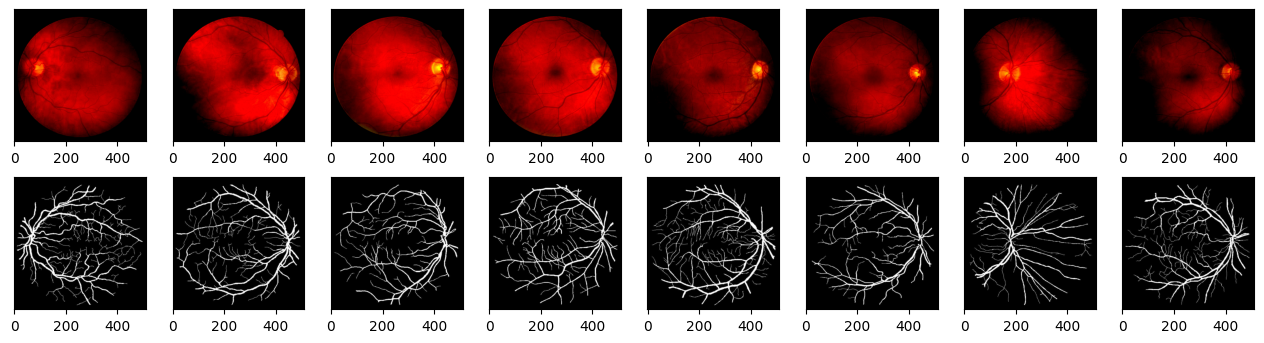

In [21]:
def show_images(imgs, masks, num_rows, num_cols, scale=2):  #@save
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (img, mask) in enumerate(zip(imgs, masks)):
        if img.is_cuda:
            img = img.cpu()
        if mask.is_cuda:
            mask = mask.cpu()
        img = img.numpy().transpose(1, 2, 0)
        mask = mask.numpy().transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[num_cols + i].imshow(mask, cmap='gray')
        axes[i].axes.get_yaxis().set_visible(False)
        axes[num_cols + i].axes.get_yaxis().set_visible(False)

    plt.show()


show_images(image, mask, 2, 8, scale=2)

## define SA-Unet model

In [7]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels=1):
        super(SpatialAttention, self).__init__()
        kernel_size = 7
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.conv = nn.Conv2d(in_channels, 1, kernel_size, stride=1, padding=(kernel_size)//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # input x: 1, 128, 64, 64
        avg_out = self.avg_pool(x)
        # avg_out = 1, 128, 1, 1
        max_out = self.max_pool(x)
        # max_out = 1, 128, 1, 1
        out = torch.cat([avg_out, max_out], dim=1)
        # out = 1, 256, 1, 1
        out = self.conv(out)
        # out = 1, 1, 1, 1
        out = self.sigmoid(out)
        # print(out)
        # out = 1, 1, 1, 1
        return x * out
        # out = 1, 64, 128, 128
    

class SA_UNet(nn.Module):
    def __init__(self):
        super(SA_UNet, self).__init__()
        #input NCHW: batch_size, channel, height, width: 1, 3, 512, 512
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # change 1 to 3
        # output 1, 16, 512, 512
        self.conv1_bn = nn.BatchNorm2d(16)
        # output 1, 16, 512, 512
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        # output 1, 16, 512, 512
        self.conv2_bn = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        # output 1, 16, 256, 256
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(32)
        # output 1, 32, 256, 256
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(32)
        # output 1, 32, 256, 256
        self.pool2 = nn.MaxPool2d(2, 2)
        # output 1, 32, 128, 128
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(64)
        # output 1, 64, 128, 128
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv6_bn = nn.BatchNorm2d(64)
        # output 1, 64, 128, 128
        self.pool3 = nn.MaxPool2d(2, 2)
        # output 1, 64, 64, 64
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv7_bn = nn.BatchNorm2d(128)
        # output 1, 128, 64, 64
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv8_bn = nn.BatchNorm2d(128) 
        # output 1, 128, 64, 64
        self.pool4 = nn.MaxPool2d(2, 2)
        # output 1, 128, 32, 32
        self.conv88 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv88_bn = nn.BatchNorm2d(256)
        # output 1, 256, 32, 32
        self.conv888 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv888_bn = nn.BatchNorm2d(256)
        # output 1, 256, 32, 32
        self.sa = SpatialAttention(512)
        self.conv999 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv999_bn = nn.BatchNorm2d(256)
        self.trans11 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        # output 1, 128, 64, 64
        self.conv99 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv99_bn = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv9_bn = nn.BatchNorm2d(128)
        # output 1, 128, 64, 64
        self.trans1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        # output 1, 64, 128, 128
        self.conv10 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv10_bn = nn.BatchNorm2d(64)
        # output 1, 64, 128, 128
        self.conv11 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv11_bn = nn.BatchNorm2d(64)
        # output 1, 64, 128, 128
        self.trans2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        # output 1, 32, 256, 256
        self.conv12 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv12_bn = nn.BatchNorm2d(32)
        # output 1, 32, 256, 256
        self.conv13 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv13_bn = nn.BatchNorm2d(32)
        # output 1, 32, 256, 256
        self.trans3 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        # output 1, 16, 512, 512
        self.conv14 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv14_bn = nn.BatchNorm2d(16)
        # output 1, 16, 512, 512
        self.conv15 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv15_bn = nn.BatchNorm2d(16)
        # output 1, 16, 512, 512
        self.conv16 = nn.Conv2d(16, 1, 1)
        # output 1, 1, 512, 512



    def forward(self, x):
        # Encoder
        # x = 1, 3, 512, 512
        x1 = F.relu(self.conv1_bn(self.conv1(x)))
        x1 = F.relu(self.conv2_bn(self.conv2(x1)))
        # x1 = 1, 16, 512, 512
        x2 = self.pool1(x1)
        # x2 = 1, 16, 256, 256
        x2 = F.relu(self.conv3_bn(self.conv3(x2)))
        x2 = F.relu(self.conv4_bn(self.conv4(x2)))
        # x2 = 1, 32, 256, 256
        x3 = self.pool2(x2)
        # x3 = 1, 32, 128, 128
        x3 = F.relu(self.conv5_bn(self.conv5(x3)))
        x3 = F.relu(self.conv6_bn(self.conv6(x3)))
        # x3 = 1, 64, 128, 128
        x4 = self.pool3(x3)
        # x4 = 1, 64, 64, 64
        x4 = F.relu(self.conv7_bn(self.conv7(x4)))
        x4 = F.relu(self.conv8_bn(self.conv8(x4)))
        # x4 = 1, 128, 64, 64
        x5 = self.pool4(x4)
        # x5 = 1, 128, 32, 32
        x5 = F.relu(self.conv88_bn(self.conv88(x5)))
        x5 = F.relu(self.conv888_bn(self.conv888(x5)))
        # x5 = 1, 256, 32, 32
        # Decoder
        x5 = self.sa(x5)
        # x5 = 1, 256, 32, 32
        x5 = F.relu(self.conv999_bn(self.conv999(x5)))
        # x5 = 1, 256, 32, 32
        x4 = torch.cat((self.trans11(x5), x4), dim=1)
        # x4 = 1, 256, 64, 64
        x4 = F.relu(self.conv99_bn(self.conv99(x4)))
        x4 = F.relu(self.conv9_bn(self.conv9(x4)))
        # x4 = 1, 128, 64, 64
        x3 = torch.cat((self.trans1(x4), x3), dim=1)
        # x3 = 1, 128, 128, 128
        x3 = F.relu(self.conv10_bn(self.conv10(x3)))
        x3 = F.relu(self.conv11_bn(self.conv11(x3)))
        # x3 = 1, 64, 128, 128
        x2 = torch.cat((self.trans2(x3), x2), dim=1)
        # x2 = 1, 64, 256, 256
        x2 = F.relu(self.conv12_bn(self.conv12(x2)))
        x2 = F.relu(self.conv13_bn(self.conv13(x2)))
        # x2 = 1, 32, 256, 256
        x1 = torch.cat((self.trans3(x2), x1), dim=1)
        # x1 = 1, 32, 512, 512
        x1 = F.relu(self.conv14_bn(self.conv14(x1)))
        x1 = F.relu(self.conv15_bn(self.conv15(x1)))
        # x1 = 1, 16, 512, 512
        x = self.conv16(x1)
        # x = 1, 1, 512, 512
        x = torch.sigmoid(x)
        # x = 1, 1, 512, 512
        return x

model = SA_UNet().to(DEVICE)

# sa_model = SpatialAttention(256).to(DEVICE)

def print_model_summary(model):
    print(model)
    print("Model Summary:")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()}")
            total_params += param.numel()
    print(f"Total Trainable Parameters: {total_params}")

print_model_summary(model)
test_input1 = torch.randn(1, 3, 512, 512).to(DEVICE)
test_output1 = model(test_input1)
print(test_output1.shape)
# test_input2 = torch.randn(1, 128, 64, 64).to(DEVICE)
# test_output2 = sa_model(test_input2)
# print(test_output2.shape)

SA_UNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

## Train model


In [8]:
# check if there is pth file and load saved model
import re
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/DRIVE_UNet")

def get_latest_model(path):
    Latest_Model = re.compile(r"DRIVE_UNET_256_(\d+).pth")
    files = os.listdir(path)
    latest_model = 0
    for file in files:
        match = Latest_Model.match(file)
        if match:
            epoch = int(match.group(1))
            if epoch > latest_model:
                latest_model = epoch
    return latest_model


def load_model(model, path):
    latest_model = get_latest_model(path)
    if latest_model > 0:
        model.load_state_dict(torch.load(os.path.join(path, f"DRIVE_UNET_{latest_model}.pth")))
        print(f"Loaded model at epoch {latest_model}")
    else:
        print("No saved model found")
    return latest_model, model

# Loss function
def dice_loss(pred, target, smooth=1.):
    """ Calculate dice loss for a batch of predictions """

    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def bce_dice_loss(pred, target):
    """ Calculate combined binary cross entropy and dice loss """

    target = F.interpolate(target, size=pred.size()[2:], mode='bilinear', align_corners=True)

    loss = F.binary_cross_entropy(pred, target) + dice_loss(pred, target)

    return loss


def IOU(pred, target):
    """ Calculate Intersection over Union for a batch of predictions """

    pred = pred.contiguous()
    target = target.contiguous()

    target = F.interpolate(target, size=pred.size()[2:], mode='bilinear', align_corners=True)

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = (pred + target).sum(dim=2).sum(dim=2) - intersection

    IOU = (intersection + 1e-6) / (union + 1e-6)

    return IOU.mean()


def SE(pred, target):
    """ Calculate Sensitivity for a batch of predictions """

    pred = pred.contiguous()
    target = target.contiguous()

    target = F.interpolate(target, size=pred.size()[2:], mode='bilinear', align_corners=True)

    TP = (pred * target).sum(dim=2).sum(dim=2)
    FN = ((1 - pred) * target).sum(dim=2).sum(dim=2)

    SE = TP / (TP + FN)

    return SE.mean()


def ACC(pred, target):
    """ Calculate Accuracy for a batch of predictions """

    pred = pred.contiguous()
    target = target.contiguous()

    target = F.interpolate(target, size=pred.size()[2:], mode='bilinear', align_corners=True)

    TP = (pred * target).sum(dim=2).sum(dim=2)
    TN = ((1 - pred) * (1 - target)).sum(dim=2).sum(dim=2)
    FP = (pred * (1 - target)).sum(dim=2).sum(dim=2)
    FN = ((1 - pred) * target).sum(dim=2).sum(dim=2)

    ACC = (TP + TN) / (TP + TN + FP + FN)

    return ACC.mean()


def AUC(pred, target):
    """ Calculate Area Under Curve for a batch of predictions """

    pred = pred.contiguous()
    target = target.contiguous()

    target = F.interpolate(target, size=pred.size()[2:], mode='bilinear', align_corners=True)

    TP = (pred * target).sum(dim=2).sum(dim=2)
    TN = ((1 - pred) * (1 - target)).sum(dim=2).sum(dim=2)
    FP = (pred * (1 - target)).sum(dim=2).sum(dim=2)
    FN = ((1 - pred) * target).sum(dim=2).sum(dim=2)

    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    AUC = (TPR + FPR) / 2

    return AUC.mean()


# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, verbose=True)

# Training function
def train(model, optimizer, scheduler, train_loader, epoch):
    """ Train the model for one epoch """

    model.train()
    train_loss = []
    train_SE = []
    train_ACC = []
    train_AUC = []
    train_IOU = []
    for i, (images, masks) in enumerate(train_loader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        # print(outputs.shape)
        # print(masks.shape)
        loss = bce_dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        train_SE.append(SE(outputs, masks).item())
        train_ACC.append(ACC(outputs, masks).item())
        train_AUC.append(AUC(outputs, masks).item())
        train_IOU.append(IOU(outputs, masks).item())



        if (i+1) % 10 == 0:
            print(f'Train Epoch: {epoch} [{i * len(images)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}\tIOU: {train_IOU[-1]:.6f}')

    scheduler.step(np.mean(train_loss))
    print(f'Train Epoch: {epoch}\tLoss: {np.mean(train_loss):.6f}\tIOU: {np.mean(train_IOU):.6f}\nSE: {np.mean(train_SE):.6f}\tACC: {np.mean(train_ACC):.6f}\tAUC: {np.mean(train_AUC):.6f}')
    writer.add_scalar('Train/Loss', np.mean(train_loss), epoch)
    writer.add_scalar('Train/IOU', np.mean(train_IOU), epoch)
    writer.add_scalar('Train/SE', np.mean(train_SE), epoch)
    writer.add_scalar('Train/ACC', np.mean(train_ACC), epoch)
    writer.add_scalar('Train/AUC', np.mean(train_AUC), epoch)


def test(model, test_loader, epoch):
    """ Test the model for one epoch """

    model.eval()
    test_loss = []
    test_IOU = []
    test_SE = []
    test_ACC = []
    test_AUC = []


    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            test_loss.append(bce_dice_loss(outputs, masks).item())
            test_IOU.append(IOU(outputs, masks).item())
            test_SE.append(SE(outputs, masks).item())
            test_ACC.append(ACC(outputs, masks).item())
            test_AUC.append(AUC(outputs, masks).item())

    print("----------------------------------------------")
    print(f'Test Epoch: {epoch}\tLoss: {np.mean(test_loss):.6f}\tIOU: {np.mean(test_IOU):.6f}\nSE: {np.mean(test_SE):.6f}\tACC: {np.mean(test_ACC):.6f}\tAUC: {np.mean(test_AUC):.6f}')
    writer.add_scalar('Test/Loss', np.mean(test_loss), epoch)
    writer.add_scalar('Test/IOU', np.mean(test_IOU), epoch)
    writer.add_scalar('Test/SE', np.mean(test_SE), epoch)
    writer.add_scalar('Test/ACC', np.mean(test_ACC), epoch)
    writer.add_scalar('Test/AUC', np.mean(test_AUC), epoch)
    print("----------------------------------------------")


latest_model, model = load_model(model, os.getcwd())
for epoch in range(latest_model+1, EPOCHS+1):
    train(model, optimizer, scheduler, train_loader, epoch)
    test(model, train_loader, epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), os.path.join(os.getcwd(), f"DRIVE_UNET_{epoch}.pth"))

writer.close()


No saved model found
Train Epoch: 1 [72/180]	Loss: 1.332412	IOU: 0.114692
Train Epoch: 1 [152/180]	Loss: 1.235666	IOU: 0.133211
Train Epoch: 1	Loss: 1.331351	IOU: 0.112755
SE: 0.570695	ACC: 0.600405	AUC: 0.483653
>>>>Test Epoch: 1	Loss: 1.324372	IOU: 0.087535
SE: 0.409908	ACC: 0.622629	AUC: 0.383309
Train Epoch: 2 [72/180]	Loss: 1.174005	IOU: 0.145684
Train Epoch: 2 [152/180]	Loss: 1.125934	IOU: 0.158657
Train Epoch: 2	Loss: 1.171119	IOU: 0.147405
SE: 0.647581	ACC: 0.669742	AUC: 0.487853
>>>>Test Epoch: 2	Loss: 1.143794	IOU: 0.133530
SE: 0.530820	ACC: 0.696842	AUC: 0.408962
Train Epoch: 3 [72/180]	Loss: 1.109952	IOU: 0.157301
Train Epoch: 3 [152/180]	Loss: 1.064108	IOU: 0.173168
Train Epoch: 3	Loss: 1.082013	IOU: 0.170246
SE: 0.677002	ACC: 0.708388	AUC: 0.482719
>>>>Test Epoch: 3	Loss: 1.062343	IOU: 0.167596
SE: 0.631184	ACC: 0.724051	AUC: 0.448986
Train Epoch: 4 [72/180]	Loss: 1.009698	IOU: 0.192310
Train Epoch: 4 [152/180]	Loss: 0.985949	IOU: 0.202830
Train Epoch: 4	Loss: 1.006333	IO

In [ ]:
writer.close()

## plot test images and masks from the trained model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


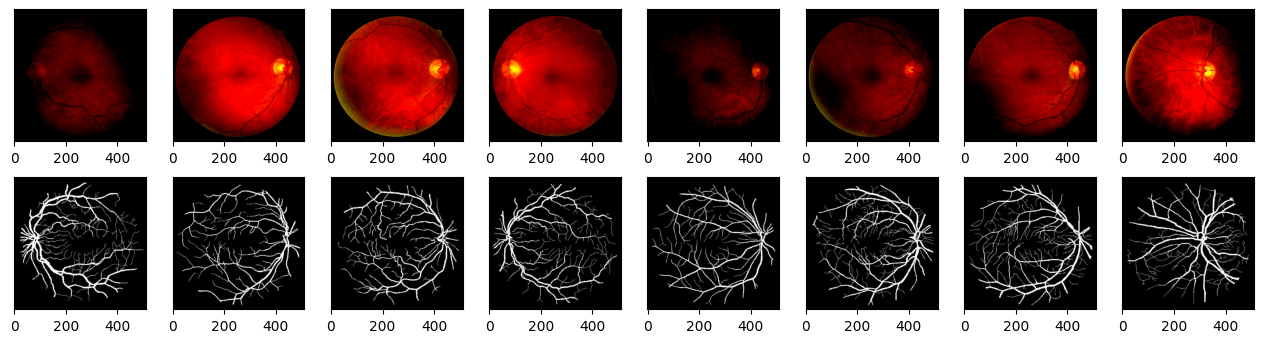

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


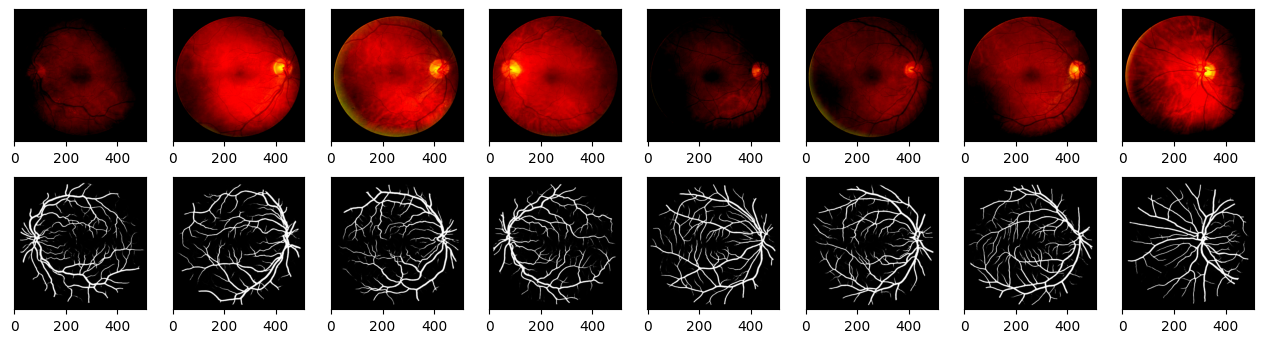

In [23]:
image, mask = next(iter(test_loader))

image = image.to(DEVICE)
mask = mask.to(DEVICE)

model.eval()
output = model(image)


show_images(image.cpu(), mask.cpu(), 2, 8, scale=2)

show_images(image.cpu(), output.detach().cpu(), 2, 8, scale=2)
